## Data

In [ ]:
!git clone https://github.com/NeuralOperator/neuraloperator
%cd neuraloperator
!pip install -e .
!pip install -r requirements.txt

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import neuralop
import numpy as np
import matplotlib.pyplot as plt
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.layers.embeddings import GridEmbedding2D

import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

import wandb

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
train_loader, test_loader, data_processor = load_darcy_flow_small(n_train=1000, batch_size=32,
                                             test_resolutions=[16, 32], n_tests=[100, 50],
                                             test_batch_sizes=[32, 32],)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [4]:
def prepare_data(data_loader):
    x, y = zip(*[batch.values() for batch in data_loader])
    x = torch.cat(x, dim=0)
    y = torch.cat(y, dim=0)

    positional_embedding = GridEmbedding2D(in_channels=1)
    x = torch.stack(list(map(lambda t: positional_embedding(t.unsqueeze(0)).squeeze(0), x))).permute(0, 2, 3, 1)
    y = y.permute(0, 2, 3, 1)

    return x, y

In [5]:
x_train, y_train = prepare_data(train_loader)
x_test, y_test = prepare_data(test_loader[16])

In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 16, 16, 3]) torch.Size([1000, 16, 16, 1])
torch.Size([50, 16, 16, 3]) torch.Size([50, 16, 16, 1])


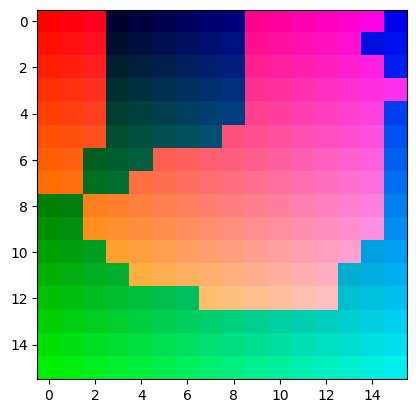

In [23]:
plt.imshow(x_train[0])
plt.show()

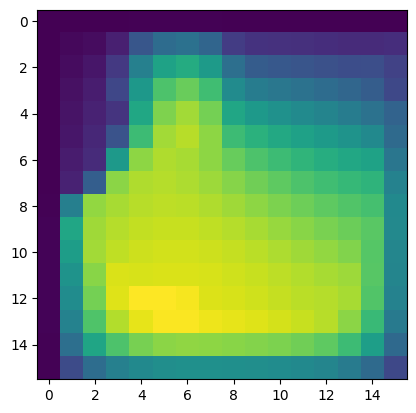

In [24]:
plt.imshow(y_train[0])
plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class create_data(Dataset):
    def __init__(self, x_mesh, y):
        self.x_mesh = x_mesh
        self.y = y

    def __len__(self):
        return len(self.x_mesh)

    def __getitem__(self, idx):
        return self.x_mesh[idx], self.y[idx]

train_dataset = create_data(x_train, y_train)
test_dataset = create_data(x_test, y_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle = False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle = False)
print(len(train_dataloader), len(test_dataloader))

## Fourier Neural Operator

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np

In [ ]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1               # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels,
                                                             self.modes1, self.modes2, dtype = torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels,
                                                              self.modes1, self.modes2, dtype = torch.cfloat))

    def complmul_2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum('bixy, ioxy -> boxy', input, weights)

    def forward(self, x):
        batch_size = x.shape[0]
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_channels,
                             x.size(-2), x.size(-1)//2 + 1, dtype = torch.cfloat, device = x.device)

        out_ft[:, :, :self.modes1, :self.modes2] = self.complmul_2d(x_ft[:, :, :self.modes1, :self.modes2],
                                                                   self.weights1)

        out_ft[:, :, -self.modes1:, -self.modes2:] = self.complmul_2d(x_ft[:, :, -self.modes1:, -self.modes2:],
                                                                   self.weights2)

        x = torch.fft.irfft2(out_ft, s = (x.size(-2), x.size(-1)))
        return x

In [ ]:
class MLP2d(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super().__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

In [ ]:
class FNOBlock2d(nn.Module):
    def __init__(self, width, modes1, modes2, add_mlp=False):
       super(FNOBlock2d, self).__init__()
       self.width = width
       self.modes1 = modes1
       self.modes2 = modes2

       self.conv = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
       self.W = nn.Conv2d(self.width, self.width, 1)

       # self.activation = nn.ReLU()

       self.add_mlp = add_mlp
       if add_mlp:
          self.mlp = MLP2d(self.width, self.width, self.width)

    def forward(self, x):
        x1 = self.conv(x)
        if self.add_mlp:
            x1 = self.mlp(x)
        x2 = self.W(x)
        return x1 + x2

In [25]:
matrix = [[0, 0, 1, 1, 1],
          [0, 0, 1, 1, 1],
          [1, 1, 0, 0, 0],
          [1, 1, 0, 0, 0],
          [1, 1, 0, 0, 0]]

def irreducible(matrix):
    adjList = defaultdict(list)

    for r in range(len(matrix)):
      for c in range(len(matrix[0])):
            if matrix[r][c] == 1:
                adjList[r].append(c)

    n = len(matrix)

    for start in range(n):
        visit = set()
        def dfs(node):
            visit.add(node)

            for neighbour in adjList[node]:
                if neighbour not in visit:
                    dfs(neighbour)

        dfs(start)

        if len(visit) < n:
            return False

    return True

In [26]:
irreducible(matrix)

True

In [ ]:
class FNO2d(nn.Module):
    def __init__(self,
                 modes1,
                 modes2,
                 width,
                 in_channels=1,
                 out_channels=1,
                 n_blocks = 4,
                 add_mlp=False):

        super(FNO2d, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.add_mlp = add_mlp
        self.n_blocks = n_blocks
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = 9

        self.p = nn.Linear(self.in_channels + 2, self.width)

        self.fno_blocks = nn.ModuleList([FNOBlock2d(self.width, self.modes1, self.modes2, self.add_mlp)
                                         for i in range(self.n_blocks)])

        self.q = MLP2d(self.width, self.out_channels, self.width * 4)

    def forward(self, x, grid=None, **kwargs):
        if grid == None:
            grid = self.get_grid(x.shape, x.device)

        x = torch.cat((x, grid), dim = -1)

        x = self.p(x)
        x = x.permute([0, 3, 1, 2])
        x = F.pad(x, [0, self.padding, 0, self.padding])

        for block in self.fno_blocks:
            x = block(x)

            # Is this required. I have added this.
            x = F.gelu(x)

        x = x[..., :-self.padding, :-self.padding]

        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

## Model Training

In [ ]:
model = FNO2d(
    modes1=12,
    modes2=12,
    width=32,
    in_channels=3,
    out_channels=1,
    n_blocks=4,
    add_mlp=True)

In [ ]:
input = torch.randn(2, 32, 32, 3)
output = model(input)
print(output.shape)

torch.Size([2, 32, 32, 1])


In [ ]:
input = next(iter(train_dataloader))[0]
output = model(input)
print(output.shape)

torch.Size([32, 16, 16, 1])


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [ ]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [ ]:
epochs = 5
batch_size = 32

In [ ]:
wandb.init(project='Fourier Neural Operator', config={'learning_rate': 0.001, 'epochs': epochs, 'batch_size': 32})

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        optimizer.zero_grad()

        output = model(x)

        loss = l2loss(output.reshape(batch_size, -1), y.reshape(batch_size, -1))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        scheduler.step()

    model.eval()
    val_loss = 0

    with torch.no_grad():
        for x_val, y_val in test_dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            output_val = model(x)

            final_loss = l2loss(output_val.reshape(batch_size, -1), y.reshape(batch_size, -1))

            val_loss += final_loss.item()

    total_train_loss = train_loss / (len(train_dataloader) * batch_size)
    total_val_loss = val_loss / (len(test_dataloader) * batch_size)
    wandb.log({'train_loss': total_train_loss, 'val_loss': total_val_loss, 'epoch': epoch})

## $ω$ using Darcy-Flow

In [ ]:
all_x, all_y = zip(*[batch.values() for batch in train_loader])
x = torch.cat(all_x, dim=0)
y = torch.cat(all_y, dim=0)
combined = torch.cat([x, y], dim=1)
print(combined.shape)

torch.Size([1000, 2, 16, 16])


In [ ]:
# Reference notebook
# y = torch.Size([64, 512, 25, 1])  # (B, s, t) -> (B, t, s)
# We will find the resolution across s

In [ ]:
# Calculate FFT and omega
RESOLUTIONS = [2, 4, 8, 16, 32, 64, 128, 256]
y_ = rearrange(combined, 'b t s1 s2 -> (b t) s1 s2')
yf = torch.fft.rfft2(y_, dim = (-2, -1))

total_amp = torch.abs(yf).sum()

omegas = []
for res in RESOLUTIONS:
   unobserved = torch.abs(yf[:, res//2:, res//2:]).sum()
   omega = (unobserved / total_amp).mean()

   print(f'Resolution {res}: {omega}')
   omegas.append(omega.item())

torch.Size([2000, 16, 16])
torch.Size([2000, 16, 9])
Resolution 2: 0.5049359798431396
Resolution 4: 0.31851351261138916
Resolution 8: 0.15529906749725342
Resolution 16: 0.018650341778993607
Resolution 32: 0.0
Resolution 64: 0.0
Resolution 128: 0.0
Resolution 256: 0.0


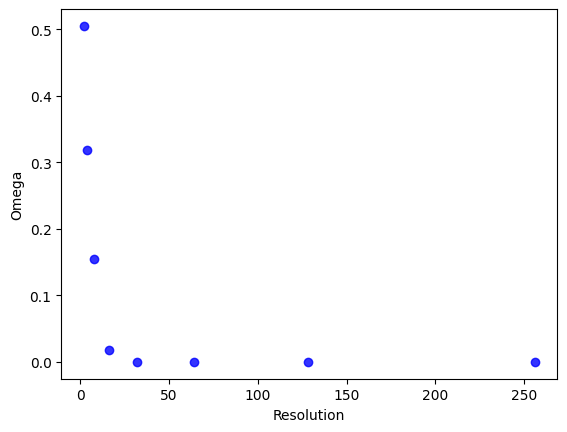

In [ ]:
plt.scatter(RESOLUTIONS, omegas,c = 'blue', alpha = 0.8)
plt.xlabel('Resolution')
plt.ylabel('Omega')
plt.show()

## Extras

In [ ]:
print(torch.rand(2, 2, dtype = torch.cfloat))

tensor([[0.3625+0.0797j, 0.9760+0.4519j],
        [0.3372+0.0865j, 0.7794+0.6300j]])


In [ ]:
B, H, W, C_in = 2, 32, 32, 3
x = torch.randn(B, H, W, C_in)
x = x.permute([0, 3, 1, 2])
x_ft = torch.fft.rfft2(x)
print(x_ft.shape)

torch.Size([2, 3, 32, 17])


In [ ]:
modes1 = 12
modes2 = 12
C_out = 3

weights = torch.rand(C_in, C_out, modes1, modes2, dtype = torch.cfloat)
print(weights.shape)

torch.Size([3, 3, 12, 12])


In [ ]:
def complmul_2d(input, weights):
    return torch.einsum('bixy, ioxy -> boxy', input, weights)

In [ ]:
output = complmul_2d(x_ft[:, :, :modes1, :modes2], weights)
print(output.shape)

torch.Size([2, 3, 12, 12])


In [ ]:
grid = model.get_grid(shape = [B, H, W], device = 'cpu')
print(grid.shape)

torch.Size([2, 32, 32, 2])


In [ ]:
x = torch.randn(B, H, W, C_in)
x_mesh = torch.cat((x, grid), dim = -1)
print(x_mesh.shape)

torch.Size([2, 32, 32, 5])


In [ ]:
x = torch.randn(B, H, W, C_in)
x = x.permute([0, 3, 1, 2])
x = F.pad(x, [0, 9, 0, 9])
print(x.shape)

torch.Size([2, 3, 41, 41])
